## Task 5 - Logistic Regression

In [21]:
# Import required libraries
import pandas as pd
import numpy as np
import re
import string
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import GridSearchCV

#### I used the XED dataset from the suggested datasets

In [2]:
# Load the XED dataset
data = pd.read_csv(r"C:\Users\40762\OneDrive\Desktop\2024-25c-fai2-adsai-NicolaIonita230632\Week 3\Data Lab\ro-projections.csv")
df = pd.DataFrame(data)
df.head(10)

,sentence,labels
0,"Hai, omule.","6, 7"
1,Am spart-o.,"1, 4"
2,"Hai, marcă banu', barosane.","2, 5"
3,Ţi-am zis să nu-mi mai spui aşa.,1
4,Îi faci tu praf pe toţi sau îi fac eu?,2
5,Cum adică sec?,7
6,"Sunteţi orbi, băieţi?",1
7,Cred că cineva a mânărit cărţile.,"1, 4"
8,Eşti nebun?,"1, 7"
9,Nu punea el 194 $ pe o amărâtă de pereche.,"1, 3"


In [3]:
#Load test dataset
testd = pd.read_csv(r"C:\Users\40762\OneDrive\Desktop\2024-25c-fai2-adsai-NicolaIonita230632\Week 3\Data Lab\group 25.csv")
td = pd.DataFrame(testd)
td.head(10)

,Start Time,End Time,Sentence,Corrected Sentence,Translation,Emotion,Intensity
0,"00:00:00,000","00:00:03,000",BOH-AM-Z 200%,BOH-AM-Z 200%,Boh-am-Z 200%,confusion,moderate
1,"00:00:03,000","00:00:09,000",ONLY ACTIVATES WHEN MEN'T ACTIVE,ONLY ACTIVATES WHEN MEN'T ACTIVE,ONLY ACTIVATES WHEN MEN'T ACTIVE,confusion,moderate
2,"00:00:11,000","00:00:19,000",LEST ARGUE,LEST ARGUE,LEST ARGUE,annoyance,moderate
3,"00:00:19,000","00:00:20,000",OUCH,OUCH,OUCH,NaN,NaN
4,"00:00:20,000","00:00:23,000",BECAUSE PEP rapt is my favorite boo and is 100...,BECAUSE PEP rapt is my favorite boo and is 100...,BECAUSE PEP rapt is my favorite boo and is 100...,joy,mild
5,"00:00:23,000","00:00:25,000",WHOOKA WHOOKA WHOOKAPEW,WHOOKA WHOOKA WHOOKAPEW,WHOOKA WHOOKA WHOOKAPEW,amusement,mild
6,"00:00:25,000","00:00:25,000",F rect,F rect,F rect,neutral,neutral
7,"00:00:25,000","00:00:26,000",S rect,S rect,S rect,neutral,neutral
8,"00:00:26,000","00:00:26,000",S rect,S rect,S rect,neutral,neutral
9,"00:00:26,000","00:00:27,000",probably,probably,probably,neutral,neutral


## Preprocessing the XED dataset

#### Since there were more emotions adnotated, I decided to only keep the first one

In [4]:
# Keep only the first emotion in 'primary_emotion' (split by commas and take the first one)
df['primary_emotion'] = df['labels'].apply(lambda x: x.split(',')[0])

# Check the first few rows to confirm that only the first emotion is kept
print(df.head(10))

                                     sentence labels primary_emotion
0                                 Hai, omule.   6, 7               6
1                                 Am spart-o.   1, 4               1
2                 Hai, marcă banu', barosane.   2, 5               2
3            Ţi-am zis să nu-mi mai spui aşa.      1               1
4      Îi faci tu praf pe toţi sau îi fac eu?      2               2
5                              Cum adică sec?      7               7
6                       Sunteţi orbi, băieţi?      1               1
7           Cred că cineva a mânărit cărţile.   1, 4               1
8                                 Eşti nebun?   1, 7               1
9  Nu punea el 194 $ pe o amărâtă de pereche.   1, 3               1


#### I had to convert the values in the primary_emotion column to numeric values.

In [5]:
df['primary_emotion'] = pd.to_numeric(df['primary_emotion'], errors='coerce')

In [6]:
print(df['primary_emotion'].unique())

[6 1 2 7 5 3 4 8]


#### Because in this dataset there were more than 7 emotions I had to remap them: first back into the words so I don't get them confused and then back into numbers to use them.

In [7]:
# Correct mapping from XED numeric codes to emotion labels
xed_to_project = {
    1: "anger",        # No change
    2: "happiness",    # Changed from "anticipation" to "happiness"
    3: "disgust",      # No change
    4: "fear",         # No change
    5: "happiness",    # Changed from "joy" to "happiness"
    6: "sadness",      # No change
    7: "surprise",     # No change
    8: "neutral"       # Changed from "trust" to "neutral"
}

# Apply the mapping
df['emotion_words'] = df['primary_emotion'].map(xed_to_project)  # Map XED numbers to emotions

# Check the DataFrame after mapping
print(df.head())

                                 sentence labels  primary_emotion  \
0                             Hai, omule.   6, 7                6   
1                             Am spart-o.   1, 4                1   
2             Hai, marcă banu', barosane.   2, 5                2   
3        Ţi-am zis să nu-mi mai spui aşa.      1                1   
4  Îi faci tu praf pe toţi sau îi fac eu?      2                2   

  emotion_words  
0       sadness  
1         anger  
2     happiness  
3         anger  
4     happiness  


In [8]:
print(df['emotion_words'].unique())

['sadness' 'anger' 'happiness' 'surprise' 'disgust' 'fear' 'neutral']


In [9]:
# Define the mapping from emotion labels to numeric codes
project_to_xed = {
    "neutral": 0,     # neutral
    "anger": 1,       # anger
    "happiness": 2,    # happiness
    "disgust": 3,     # disgust
    "fear": 4,         # fear
    "sadness": 5,      # sadness
    "surprise": 6      # surprise
}

# Apply the mapping back to numeric codes
df['final_emotion'] = df['emotion_words'].map(project_to_xed)  # Map emotion words back to numeric values

# Check the DataFrame after mapping
print(df.head())

                                 sentence labels  primary_emotion  \
0                             Hai, omule.   6, 7                6   
1                             Am spart-o.   1, 4                1   
2             Hai, marcă banu', barosane.   2, 5                2   
3        Ţi-am zis să nu-mi mai spui aşa.      1                1   
4  Îi faci tu praf pe toţi sau îi fac eu?      2                2   

  emotion_words  final_emotion  
0       sadness              5  
1         anger              1  
2     happiness              2  
3         anger              1  
4     happiness              2  


In [10]:
print(df['final_emotion'].unique())

[5 1 2 6 3 4 0]


#### Like in task 4, I had to clean the sentences in order to use them

In [11]:
# Define a function to clean sentences
def clean_sentence(sentence):
    # Check if the sentence is a string and not NaN or float
    if isinstance(sentence, str):
        # Convert to lowercase
        sentence = sentence.lower()
        # Remove punctuation and special characters
        sentence = re.sub(r'[^\w\s]', '', sentence)  # Remove punctuation
        # Remove extra spaces
        sentence = re.sub(r'\s+', ' ', sentence).strip()  # Replace multiple spaces with a single space
    else:
        sentence = ''  # If it's not a valid string, return an empty string
    return sentence

# Apply the cleaning function to the 'sentence' column
df['Cleaned_Sentence'] = df['sentence'].apply(clean_sentence)

# Check the DataFrame after cleaning
df.head()

,sentence,labels,primary_emotion,emotion_words,final_emotion,Cleaned_Sentence
0,"Hai, omule.","6, 7",6,sadness,5,hai omule
1,Am spart-o.,"1, 4",1,anger,1,am sparto
2,"Hai, marcă banu', barosane.","2, 5",2,happiness,2,hai marcă banu barosane
3,Ţi-am zis să nu-mi mai spui aşa.,1,1,anger,1,ţiam zis să numi mai spui aşa
4,Îi faci tu praf pe toţi sau îi fac eu?,2,2,happiness,2,îi faci tu praf pe toţi sau îi fac eu


In [12]:
# Drop rows with NaN values in the target variable (final_emotion)
df_cleaned = df.dropna(subset=['final_emotion'])

## Preprocessing the test dataset

In [13]:
# Keep relevant columns
td = td[['Corrected Sentence', 'Emotion']]

# Slice dataset from row 297 onward
td = td[297:]

# Check the shape after slicing
print(f"Data shape after slicing: {td.shape}")

# Define emotion mapping
emotion_mapping = {
    "happiness": ["joy", "optimism", "approval", "pride", "gratitude", "confidence",
        "satisfaction", "hope", "love", "excitement", "caring", "relief", "admiration",
        "amusement", "anticipation", "encouragement", "desire", "happiness"],
    "sadness": ["disappointment", "nostalgia", "remorse", "pain", "stress", "regret",
        "resignation", "despair", "confusion", "uncertainty", "sadness"],
    "anger": ["anger", "annoyance", "disapproval", "frustration", "disbelief", "warning",
        "rejection"],
    "disgust": ["disgust"],
    "fear": ["fear", "nervousness", "worry", "anxiety", "doubt", "insecurity", "urgency",
        "panic"],
    "surprise": ["surprise", "realization", "shock", "amazement", "wonder"],
    "neutral": ["neutral", "mixed", "trust", "agreement", "instruction", "suggestion",
        "request", "confirmation", "acceptance", "reassurance", "clarification",
        "understanding", "certainty"]
}

# Create lookup dictionary
lookup = {emotion: category for category, emotions in emotion_mapping.items() for emotion in emotions}

# Map emotions to main categories
td["Emotion"] = td["Emotion"].map(lookup)

# Check the number of NaN values in the "Emotion" column
print(f"Number of NaN values in 'Emotion' column after mapping: {td['Emotion'].isna().sum()}")

# Drop NaNs and duplicates
td = td.dropna(subset=["Emotion"])
td = td.drop_duplicates(subset=["Corrected Sentence"])

# Check the shape after dropping NaNs and duplicates
print(f"Data shape after dropping NaNs and duplicates: {td.shape}")

# Encode labels
label_encoder = LabelEncoder()
td['Emotion'] = label_encoder.fit_transform(td['Emotion'])

# Display the first 10 rows
print(td.head(10))

Data shape after slicing: (1715, 2)
Number of NaN values in 'Emotion' column after mapping: 173
Data shape after dropping NaNs and duplicates: (1281, 2)
                                    Corrected Sentence  Emotion
297  Și să mai schimb momentul, că atunci când le-a...        5
299                    Piatra de moară a acestui grup.        0
300                                 Victor, zi Victor.        4
301                          Hai dragă, încurajează-o.        4
303                  Nu-mi place cum se văd saltalele.        0
304  Hai, doar dă-i un dislike pe acela, că nu mai ...        0
305                            Victor, stai așa, uite.        3
306                               Le țin eu așa, uite.        4
307                            Da, ia uite, ține fata.        3
308                  Dar până unde ajungești, nu rola.        4


## EDA

In [14]:
# Check for missing values in df
print("Missing values in df:")
print(df.isna().sum())

# Check for missing values in td
print("\nMissing values in td:")
print(td.isna().sum())

Missing values in df:
sentence            1
labels              0
primary_emotion     0
emotion_words       0
final_emotion       0
Cleaned_Sentence    0
dtype: int64

Missing values in td:
Corrected Sentence    0
Emotion               0
dtype: int64


In [15]:
# Drop rows with missing values in df
df = df.dropna()

# Drop rows with missing values in td
td = td.dropna()

# Check the shape of the datasets after dropping missing values
print(f"Shape of df after dropping missing values: {df.shape}")
print(f"Shape of td after dropping missing values: {td.shape}")

Shape of df after dropping missing values: (9474, 6)
Shape of td after dropping missing values: (1281, 2)


#### TF-IDF

In [18]:
# Step 1: Vectorize the sentences in df using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_df = tfidf_vectorizer.fit_transform(df['Cleaned_Sentence'])  # Fit and transform on df

# Step 2: Vectorize the sentences in td using the same TF-IDF vectorizer
X_td = tfidf_vectorizer.transform(td[r'Corrected Sentence'])  # Transform td using the fitted vectorizer

### Training

In [22]:
# Step 3: Define the target variable for df (emotion labels)
y_df = df['final_emotion']

# Step 4: Split the df data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=42)

# Step 5: Apply SMOTE to balance the classes in the training data (X_train, y_train)
smote = SMOTE(sampling_strategy='auto', random_state=42)  # You can change the sampling_strategy if needed
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the distribution of classes after resampling
print(f"Before resampling: {Counter(y_train)}")
print(f"After resampling: {Counter(y_train_resampled)}")

# Step 6: Define your parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],               # Regularization strength
    'solver': ['liblinear', 'saga'],      # Solvers for optimization
    'class_weight': ['balanced', None]    # Weight classes for imbalance
}

# Step 7: Initialize the Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)

# Step 8: Initialize GridSearchCV with Logistic Regression and parameter grid
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1)

# Step 9: Fit GridSearchCV to the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Step 10: Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Step 11: Use the best model for predictions
best_lr_model = grid_search.best_estimator_

Before resampling: Counter({2: 2093, 1: 1763, 4: 704, 5: 642, 6: 496, 0: 468, 3: 465})
After resampling: Counter({4: 2093, 2: 2093, 5: 2093, 1: 2093, 6: 2093, 0: 2093, 3: 2093})
Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Parameters: {'C': 100, 'class_weight': 'balanced', 'solver': 'saga'}


### Testing

In [24]:
# Make predictions using the best model
y_pred_best = best_lr_model.predict(X_test)

# Step 13: Evaluate the model
from sklearn.metrics import classification_report
print("Classification Report (Best Model):")
print(classification_report(y_test, y_pred_best))

Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.22      0.24      0.23       190
           1       0.44      0.36      0.40       780
           2       0.48      0.45      0.47       868
           3       0.17      0.18      0.17       191
           4       0.18      0.30      0.22       298
           5       0.24      0.25      0.24       269
           6       0.23      0.18      0.20       247

    accuracy                           0.34      2843
   macro avg       0.28      0.28      0.28      2843
weighted avg       0.35      0.34      0.34      2843



### Plotting

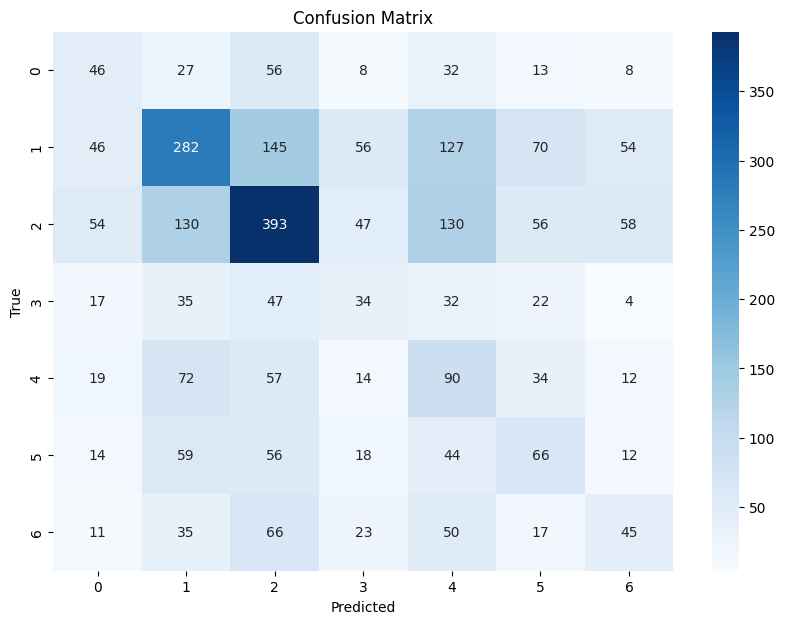

In [26]:
# Step 14: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)

# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=best_lr_model.classes_, yticklabels=best_lr_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

The classification report for the best model (using SMOTE with GridSearchCV) shows modest improvements over the initial model that only used SMOTE. The accuracy of the best model is 0.34 (34%), which is slightly better than the 0.32 (32%) accuracy achieved by the initial model. This indicates that the combination of SMOTE and hyperparameter tuning improved the overall prediction performance, albeit marginally. However, the accuracy is still low, suggesting that there is room for further improvement in the model's ability to classify the different emotion categories correctly.

When examining the class-wise performance, we can see some improvements, but challenges persist. For example, class 2 shows the best performance in terms of precision (0.48), recall (0.45), and F1-score (0.47), indicating that the model performs relatively well in identifying this class. In contrast, class 0, class 3, and class 4 still struggle, with low precision and recall values, especially for class 3, where both precision (0.17) and recall (0.18) are quite poor. These low values suggest that the model fails to identify these classes properly, resulting in high misclassification rates.

Despite the improvements made by applying SMOTE and performing hyperparameter tuning, the model still has a lot of challenges to address. The poor performance in several classes, particularly those with fewer samples, highlights the ongoing issue with class imbalance. The model's ability to generalize across all emotion classes is limited, and the low performance in key classes suggests that further refinement is needed. To improve, further exploration of alternative resampling techniques like ADASYN, trying different classification models such as Random Forest or Gradient Boosting, and enhancing feature engineering could be beneficial. Additionally, more advanced hyperparameter tuning and addressing the imbalance with more sophisticated techniques may lead to better results.